In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.optimize
import numpy as np
from collections import OrderedDict

def bisect(func, fx, x_min, x_max, max_iter=100, tol=1e-6):
    left = x_min
    right = x_max
    mid = np.zeros(len(fx))
    
    f_left = func(left)-fx
    f_right = func(right)-fx
    
    update_indices = np.arange(len(fx))    
 
    for it in range(max_iter):
        if it == 0:
            assert np.all(np.sign(f_left)!=np.sign(f_right)),\
            "Function values of x_min and x_max must have different sign!"
        mid[update_indices] = (left[update_indices]+right[update_indices])/2
        f_mid = func(mid[update_indices])-fx[update_indices]
        # whether the left points have the same signs of function values as the midpoints
        same_sign = np.sign(f_left)==np.sign(f_mid)
        # the left points that need to be replaced by the midpoints
        move2right = update_indices[same_sign]
        move2left = update_indices[~same_sign]
        # update
        left[move2right] = mid[move2right]
        f_left[move2right] = f_mid[same_sign]
        right[move2left] = mid[move2left]
        f_right[move2left] = f_mid[~same_sign]
        update_indices = update_indices[np.abs(f_mid)>tol]
        if len(update_indices) == 0: 
            # jump out of the loop if no midpoint needs to be updated
            break
    return mid

class PlanarFlow(nn.Module):
    """
    z_{k+1} = z_k + utanh(w^Tz_k+b)
    w: projection
    b: bias
    u: expanding/contracting direction
    """
    def __init__(self, input_dim):
        super(PlanarFlow, self).__init__()
        self.input_dim = input_dim
        self.direction = nn.Parameter(
            nn.init.xavier_normal_(torch.empty(1, self.input_dim)))
        self.projection = nn.Parameter(
            nn.init.xavier_normal_(torch.empty(1, self.input_dim)))
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        wxb = torch.sum(x*self.projection,dim=-1,keepdim=True)+self.bias
        hx = torch.tanh(wxb)
        Dhx = 1/(torch.cosh(wxb))**2
        coef = (self.projection*self.direction).sum(dim=-1,keepdim=True)
        return x + self.direction*hx, (1+Dhx*coef).abs()
    
    def modify(self):
        coef = torch.sum(self.projection*self.direction)  # w^Tu
        # in order to guarantee invertibility
        # it suffices to have w^Tu > -1
        # we follow the appendix to modify u
        if coef <= -1:
            m_coef = -1+torch.log(1+torch.exp(coef))
            unit_proj = self.projection.data/torch.sum(self.projection.data**2).sqrt()
            self.direction.data = self.direction.data+(m_coef-coef)*unit_proj
            
    def get_func(self, z):
        coef = (self.projection*self.direction).sum().item()
        bias = self.bias.item()
        def func(x):
            fx = x+coef*np.tanh(x+bias)
            return fx-z
        return func
        
    def inverse_base(self, z):
        with torch.no_grad():
            coef = (self.projection*self.direction).sum().item()
            fx = np.sum(self.projection.cpu().numpy()*z)
            f = self.get_func(fx)
            parallel = scipy.optimize.bisect(self.get_func(fx), fx-coef, fx+coef)
            hx = np.tanh(parallel+self.bias.item())
            return z - self.direction.cpu().numpy()*hx
    
    def inverse(self, z):
        coef = (self.projection*self.direction).sum().item()
        bias = self.bias.item()
#         def mapping(x):
#             fx = x+coef*np.tanh(x+bias)
#             return fx
        out = []
        for row in np.vsplit(z, len(z)):
            out.append(self.inverse_base(row))
        return np.vstack(out)
        fx = np.sum(self.projection.cpu().numpy()*z, axis=-1)
        parallel = bisect(mapping, fx, x_min=fx-coef, x_max=fx+coef)
        hx = np.tanh(parallel+bias)
        return z - self.direction.cpu().numpy()*hx[:, None]


class NormalizingFlow(nn.Module):
    def __init__(
        self,
        input_dim,
        n_maps,
        transformation="planar"
    ):
        super(NormalizingFlow, self).__init__()
        self.input_dim = input_dim
        self.n_maps = n_maps
        self.transformation = transformation
        self.flows = nn.Sequential(OrderedDict(
            (f"flow_{i}", self.get_flow() )
            for i in range(self.n_maps)
        ))
    
    def __iter__(self):
        self.map_id = 0
        return self
        
    def __next__(self):
        if self.map_id < self.n_maps:
            flow = getattr(self.flows, f"flow_{self.map_id}")
            self.map_id += 1
            return flow
        else:
            raise StopIteration
    
    def get_flow(self):
        if self.transformation == "planar":
            return PlanarFlow(self.input_dim)
        elif self.transformation == "radial":
            pass
    def forward(self, x):
        logp = 0
        for flow in self:
            x, det = flow(x)
            logp += torch.log(det).mean()
        logp += -(x.size(1)/2)*np.log(2*np.pi)
        logp += -(x**2).sum(dim=1).mean()/2
        return -logp
    def modify(self):
        for flow in self:
            flow.modify()
    def inverse(self, z):
        with torch.no_grad():
            x = np.array(z.clone())
            for flow in self:
                x = flow.inverse(x)
        return x

In [133]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

root = "~/datasets"
transform = transforms.ToTensor()

train_data = datasets.MNIST(root=root, download=False, train=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=512)

# digit = 1
# digit_data = train_data.data[train_data.targets==digit]/255

# class SingleDigit(Dataset):
#     def __init__(self, data):
#         self.data = data
#     def __getitem__(self, idx):
#         return self.data[idx]
#     def __len__(self):
#         return len(self.data)
    
# train_loader = DataLoader(SingleDigit(digit_data), batch_size=512)

In [41]:
from tqdm import tqdm
from torch.optim import SGD, Adam


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28*28
n_layers = 10

planar_flow = NormalizingFlow(input_dim, n_layers)
planar_flow.to(device)

n_epochs = 10
# optimizer = SGD(planar_flow.parameters(), lr=0.01, momentum=0.8, weight_decay=0, nesterov=True)
optimizer = Adam(planar_flow.parameters(), lr=0.001, weight_decay=5e-3)

for e in range(n_epochs):
    with tqdm(train_loader, desc=f"{e}/{n_epochs} epochs") as t:
        train_neg_logp = 0
        train_total = 0
        for i, x in enumerate(t):
            neg_logp = planar_flow(x.flatten(start_dim=1).to(device))
            optimizer.zero_grad()
            neg_logp.backward()
            optimizer.step()
            planar_flow.modify()
            train_neg_logp += neg_logp.item()*x.size(0)
            train_total += x.size(0)
            t.set_postfix({"train_neg_logp": train_neg_logp/train_total})

0/10 epochs:   0%|                                                                              | 0/10 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (2) must match the size of tensor b (784) at non-singleton dimension 1

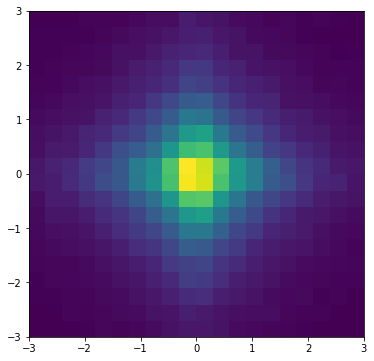

In [150]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1234)
toy_data = np.random.laplace(size=(100000, 2))

plt.figure(figsize=(6, 6))
_ = plt.hist2d(
    toy_data[:,0], toy_data[:,1], 
    range=[[-3,3],[-3,3]],
    bins=(20, 20),
    density=True
)

In [178]:
from tqdm import tqdm
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 2
n_layers = 5

planar_flow = NormalizingFlow(input_dim, n_layers)
planar_flow.to(device)

n_epochs = 30
optimizer = Adam(planar_flow.parameters(), lr=0.001, weight_decay=5e-3)


class ToyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(data)

ds = ToyDataset(toy_data)
train_loader = DataLoader(ds, batch_size=1000)
    
for e in range(n_epochs):
    with tqdm(train_loader, desc=f"{e+1}/{n_epochs} epochs") as t:
        train_neg_logp = 0
        train_total = 0
        for i, x in enumerate(t):
            neg_logp = planar_flow(x.flatten(start_dim=1).to(device))
            optimizer.zero_grad()
            neg_logp.backward()
            optimizer.step()
            planar_flow.modify()
            train_neg_logp += neg_logp.item()*x.size(0)
            train_total += x.size(0)
            t.set_postfix({"train_neg_logp": train_neg_logp/train_total})

30/30 epochs: 100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 51.02it/s, train_neg_logp=4.62]


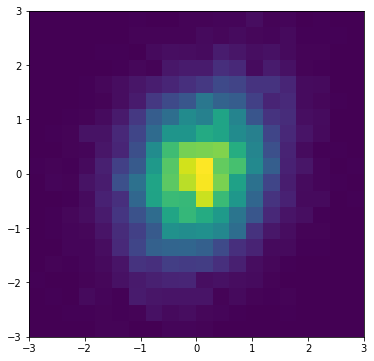

In [179]:
z = torch.randn((10000, 2))
x = planar_flow.inverse(z)

plt.figure(figsize=(6, 6))
_ = plt.hist2d(
    x[:,0], x[:,1], 
    range=[[-3,3],[-3,3]],
    bins=(20, 20),
    density=True
)